In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm
import xesmf as xe
import datetime

In [2]:
ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/EAS/OutputDir/GEOSChem.AerosolMass.201601*', combine = 'by_coords')

In [3]:
ds_base = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/CEDS/OutputDir/GEOSChem.AerosolMass.201601*', combine = 'by_coords')

In [4]:
ds_emisbase = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/CEDS/OutputDir/HEMCO_diagnostics.201601*', combine = 'by_coords')

In [5]:
ds_emispulse = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/EAS/OutputDir/HEMCO_diagnostics.201601*.nc', combine = 'by_coords')

In [6]:
height = pd.read_excel('gc_altitude.xlsx')

In [7]:
height_ds = height.diff().dropna().to_xarray().rename({'index':'lev'})
height_ds['lev'] = ds_base['lev']
height_ds = height_ds.rename({'altitude':'dz'}) 
height_ds['dz']*=1e3


In [8]:
ds_emisbase = xr.merge([ds_emisbase, height_ds], join = 'inner')
ds_emispulse = xr.merge([ds_emispulse, height_ds], join = 'inner')
ds_base = xr.merge([ds_base, height_ds], join = 'inner')
ds_delta = xr.merge([ds_delta, height_ds], join = 'inner')
#ds_conc2x = xr.merge([ds_conc2x, height_ds], join = 'inner')
#ds_emis2x = xr.merge([ds_emis2x, height_ds], join = 'inner')

In [9]:
sec_day = 86400

In [10]:
for ds in [ds_emispulse, ds_emisbase]:
    utils.combine_BC(ds)

## Import China Coal Data

In [12]:
ds_china_emis = xr.open_dataset('BC_2001_total.nc')

In [181]:
ds_china_emis['time'] = pd.to_datetime(ds_china_emis['time'], format='%Y%m')

In [182]:
ds_china_daily = ds_china_emis.resample(time="1D").interpolate("linear")

## Create GF

In [183]:
G = utils.calc_δc_δt_global(ds_delta, ds_base, 'AerMassBC')
G = G.assign_coords(time = np.arange(0.5,len(G['time'])+ 0.5))

f0 = (utils.global_w_mean(ds_emispulse, 'EmisBC_Total') - 
      utils.global_w_mean(ds_emisbase, 'EmisBC_Total'))
f0 = f0.assign_coords(time = np.arange(0.5,len(f0['time'])+0.5))


## Create Emissions Profiles

In [185]:
regridder = xe.Regridder(ds_china_daily, ds_base, 'conservative') #check this usage
regridder

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_1800x3600_46x72.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1800, 3600) 
Output grid shape:          (46, 72) 
Periodic in longitude?      False

In [186]:
ds_china_regrid = regridder(ds_china_daily)

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [204]:
## will need to update the time to include many years (not sure how to best do this...)

In [192]:
ds_china_regrid['time'] = pd.date_range("2016-01-01T12", periods=len(ds_china_regrid['time']))

In [193]:
ds_base['emis_traj'] = ds_china_regrid['emission']

In [194]:
#lev mean of G 
f = (utils.global_w_mean(ds_base, 'emis_traj'))
f= f.assign_coords(time = np.arange(0,len(f['time']))) #inputting a x2 until we get our doubled emissions as daily data

## Convolve

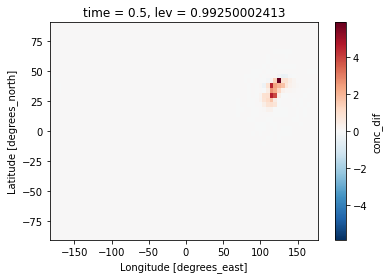

In [195]:
G.isel(time = 0, lev = 0).plot()

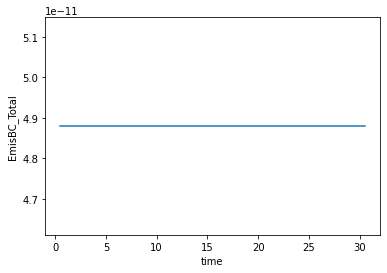

In [196]:
f0.plot()

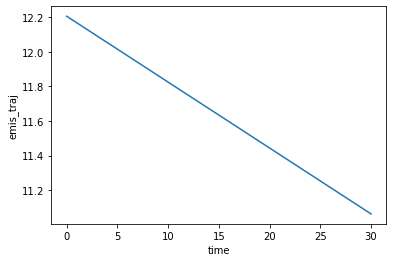

In [197]:
f.plot()

In [198]:
## check that the regridding integral works
## check that the interpolation works

In [200]:
Ndt = 20
dt = 1 #days
tp_range = np.arange(0, dt*Ndt, dt)
t_range = tp_range+0.5
Δt = 1.


In [201]:
C_ds = xr.Dataset(
    data_vars = dict(c = (["tp","lev","lat","lon","time"], np.zeros([len(tp_range),len(ds_base['lev']),len(ds_base['lat']),len(ds_base['lon']),len(G['time'])]))),
    coords = dict(
        tp = tp_range,
        lev = ("lev", ds_base['lev']),
        lat = ("lat", ds_base['lat']),
        lon = ("lon", ds_base['lon']),
        time = G['time']
    )

)

In [202]:
for i, tp in enumerate(tp_range):
    for t in t_range:
        C_ds['c'].loc[dict(tp = tp, time = t)] = utils.G_f_kernel(G, f, t, tp,Δt, dt, f0)
        


In [165]:
C_df = C_ds.isel(lev = 0).sel(lat = 35, lon = 105, method = 'nearest').drop(['lat','lon','lev']).to_dataframe().unstack()

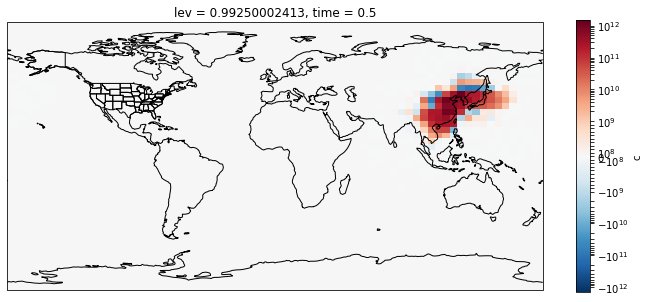

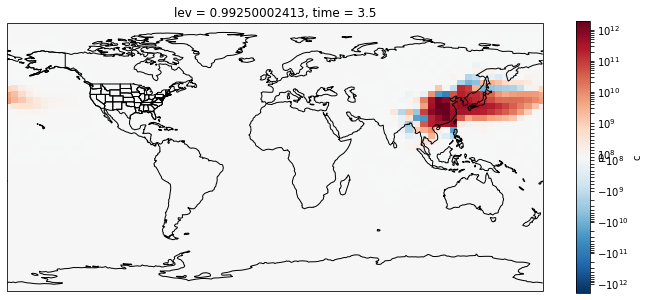

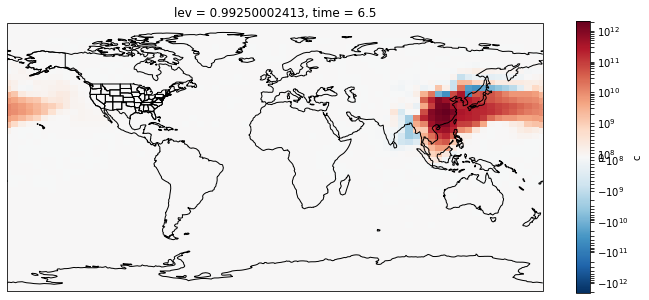

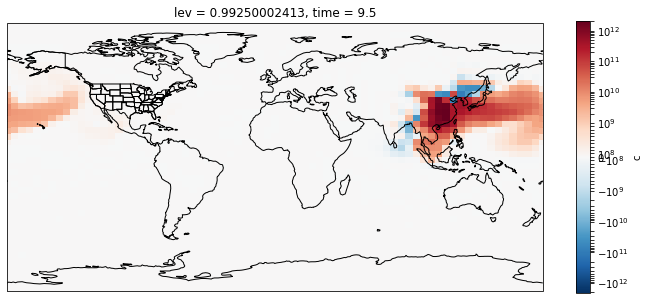

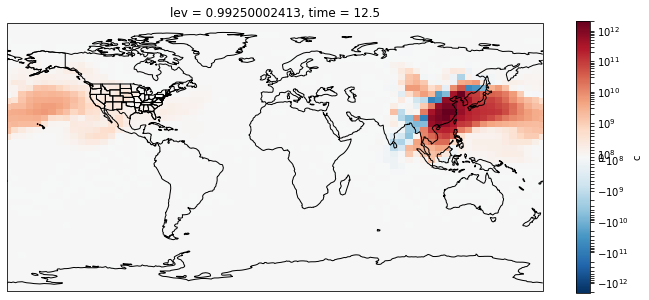

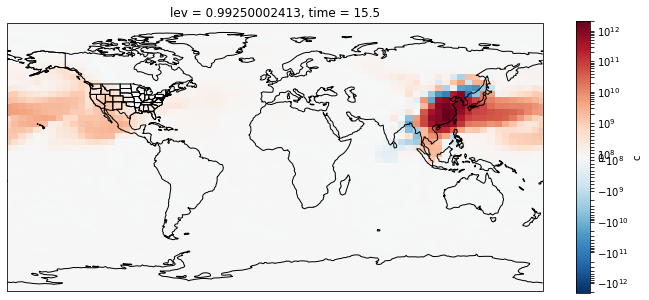

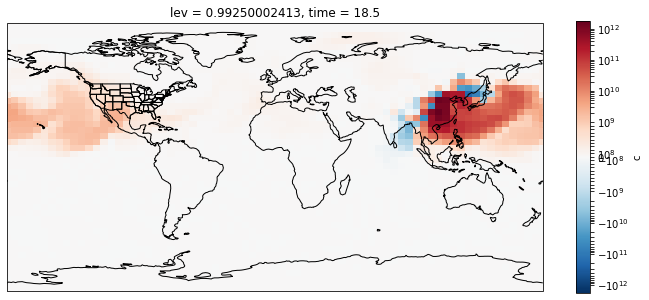

In [205]:
for t in [0,3,6,9,12,15,18]:
    fig, ax = plt.subplots( figsize = [12,5], subplot_kw={'projection':ccrs.PlateCarree()})
    vmin = 0
    vmax = .1
    C_ds.sum(dim = 'tp').isel(lev = 0, time = t)['c'].plot(ax = ax, transform = ccrs.PlateCarree(),norm = SymLogNorm(linthresh = 1e9))
    ax.coastlines()
    ax.add_feature(cfeat.STATES)